# Notebook de Démonstration des IA: YOLO, MiDaS et Pytesseract

Ce notebook présente des exemples d'utilisation de trois IA différentes : YOLO pour la détection d'objets, MiDaS pour l'estimation de profondeur, et Tesseract pour la détection de texte. Enfin, nous montrerons comment combiner ces trois IA dans une application commune.

## Installation des Bibliothèques Nécessaires

```bash
pip install torch torchvision ultralytics opencv-python-headless pytesseract
```

**Importation des Bibliothèques**

In [1]:
import cv2
import torch
import numpy as np
from ultralytics import YOLO
from torchvision.transforms import Compose, Resize, ToTensor, Normalize
from torchvision.transforms.functional import InterpolationMode
from PIL import Image
import matplotlib.pyplot as plt
import pytesseract

device = "mps" # pour utiliser le moteur de calcul de l'Apple M1 (GPU)

import sys
import os

# Méthode d'indexation des modules AssistEye pour utiliser en dehors du dossier src
def configure():
    sys.path.append(os.path.join(os.path.dirname(os.path.abspath('')), 'src'))
    print(sys.path)

configure()

['/opt/anaconda3/envs/assisteye/lib/python39.zip', '/opt/anaconda3/envs/assisteye/lib/python3.9', '/opt/anaconda3/envs/assisteye/lib/python3.9/lib-dynload', '', '/opt/anaconda3/envs/assisteye/lib/python3.9/site-packages', '/opt/anaconda3/envs/assisteye/lib/python3.9/site-packages/setuptools/_vendor', '/var/folders/xy/m7l0054j109bmgwgbp71ck5w0000gn/T/tmptfvev88u', '/Users/quentinpierson/Documents/AssistEye-Module/src']


**Détection d'Objets avec YOLO**

YOLO (You Only Look Once) est un modèle de détection d'objets en temps réel.


0: 640x480 4 persons, 1 bus, 382.4ms
Speed: 11.7ms preprocess, 382.4ms inference, 117.5ms postprocess per image at shape (1, 3, 640, 480)


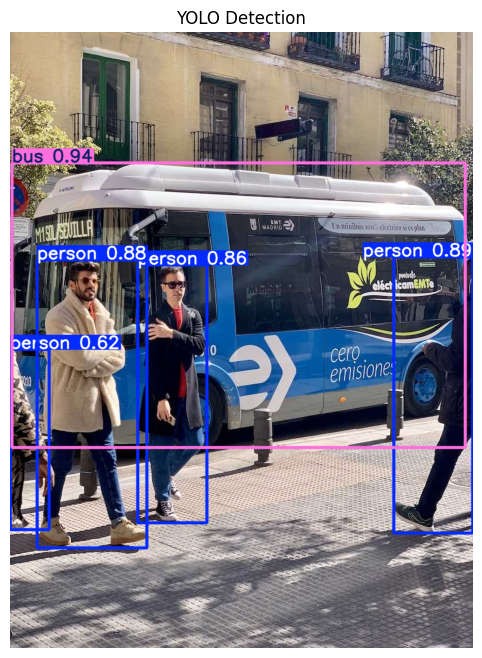

In [2]:
# Charger le modèle YOLO
model_name = 'yolo11n.pt'
model = YOLO(model_name).to(device)

# Charger une image
image_path = '/Users/quentinpierson/Documents/AssistEye/Yolo-dist-detection/examples/bus.jpg'
image = cv2.imread(image_path)

# Détection des objets
results = model(image, conf=0.4)

# Annoter et afficher l'image
annotated_image = results[0].plot()
annotated_image_rgb = cv2.cvtColor(annotated_image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 8))
plt.imshow(annotated_image_rgb)
plt.title("YOLO Detection")
plt.axis('off')
plt.show()

**Estimation de Profondeur avec MiDaS**

MiDaS est un modèle développé par Intel pour l'estimation de profondeur monoculaire.

Using cache found in /Users/quentinpierson/.cache/torch/hub/intel-isl_MiDaS_master
/opt/anaconda3/envs/assisteye/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/opt/anaconda3/envs/assisteye/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


Loading weights:  None


Using cache found in /Users/quentinpierson/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


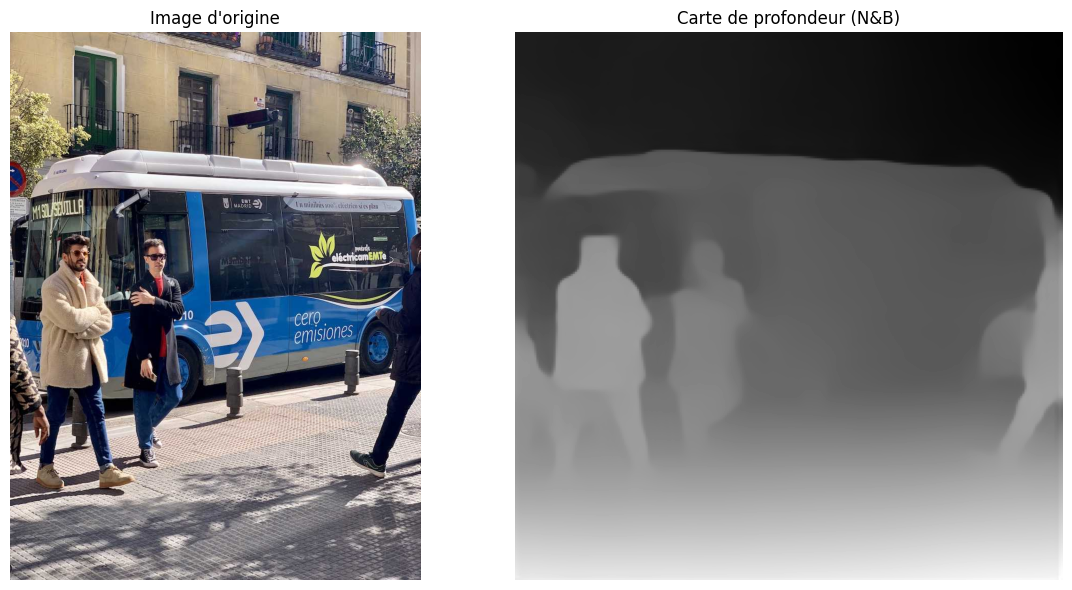

In [3]:
# Charger le modèle MiDaS
midas = torch.hub.load("intel-isl/MiDaS", "MiDaS_small").to(device)
midas.eval()

# Transformation de prétraitement pour MiDaS
transform = Compose([
    Resize((256, 256), interpolation=InterpolationMode.BILINEAR),
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Prétraitement de l'image
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # Conversion en RGB
pil_image = Image.fromarray(image_rgb)  # Conversion en Image PIL
input_batch = transform(pil_image).unsqueeze(0).to(device)

# Estimation de la profondeur
with torch.no_grad():
    depth_map = midas(input_batch).squeeze().cpu().numpy()

# Normalisation de la carte de profondeur pour affichage
depth_map_normalized = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())

# Affichage des images côte à côte
plt.figure(figsize=(12, 6))

# Image d'origine
plt.subplot(1, 2, 1)
plt.imshow(image_rgb)
plt.title("Image d'origine")
plt.axis('off')

# Carte de profondeur en noir et blanc
plt.subplot(1, 2, 2)
plt.imshow(depth_map_normalized, cmap='gray')  # Utilisation de la colormap 'gray'
plt.title("Carte de profondeur (N&B)")
plt.axis('off')

# Affichage
plt.tight_layout()
plt.show()

## ⚠️ Attention

### Facteur de Profondeur avec MiDaS

MiDaS fournit une carte de profondeur relative, ce qui signifie que les valeurs de profondeur ne sont pas en unités absolues (comme les mètres), mais plutôt des valeurs relatives qui indiquent la profondeur par rapport aux autres parties de l'image. Pour convertir ces valeurs en distances approximatives, nous utilisons un facteur de profondeur.

ROI signifie "Region of Interest" (région d'intérêt en français). Dans le contexte de l'analyse d'images ou de la vision par ordinateur, une ROI est une portion spécifique de l'image sur laquelle on souhaite se concentrer pour effectuer des calculs ou des analyses.

Pour expliquer le calcul de la fonction `convert_depth_to_distance` plus techniquement, prenons un exemple. Supposons que nous avons une profondeur moyenne de 500 unités dans une ROI et que nous voulons convertir cette profondeur en distance en mètres.

In [4]:
def convert_depth_to_distance(depth, scale_factor):
    """
    Convertit la profondeur en distance en utilisant un facteur de mise à l'échelle.
    
    :param depth: Profondeur moyenne de la ROI
    :param scale_factor: Facteur de mise à l'échelle pour convertir la profondeur en mètres
    :return: Distance en mètres
    """
    return depth * scale_factor

# Exemple d'utilisation
depth = 500  # profondeur moyenne en unités arbitraires
scale_factor = 0.001  # facteur de mise à l'échelle pour convertir en mètres

distance = convert_depth_to_distance(depth, scale_factor)
print(f"La distance est de {distance} mètres")

La distance est de 0.5 mètres


Dans cet exemple, nous avons une profondeur moyenne de 500 unités et un facteur de mise à l'échelle de 0.001. Le calcul de la distance serait donc :

```
distance = 500 * 0.001 = 0.5 mètres
```

Si nous voulons convertir cette distance en pas (en supposant qu'un pas mesure environ 0.75 mètres), nous pouvons faire le calcul suivant :

In [5]:
distance = convert_depth_to_distance(depth, scale_factor)
distance_in_steps = distance / 0.75
print(f"La distance est de {distance_in_steps} pas")

La distance est de 0.6666666666666666 pas


**Détection de Texte avec Tesseract**

Tesseract est un moteur OCR (Optical Character Recognition) open-source.

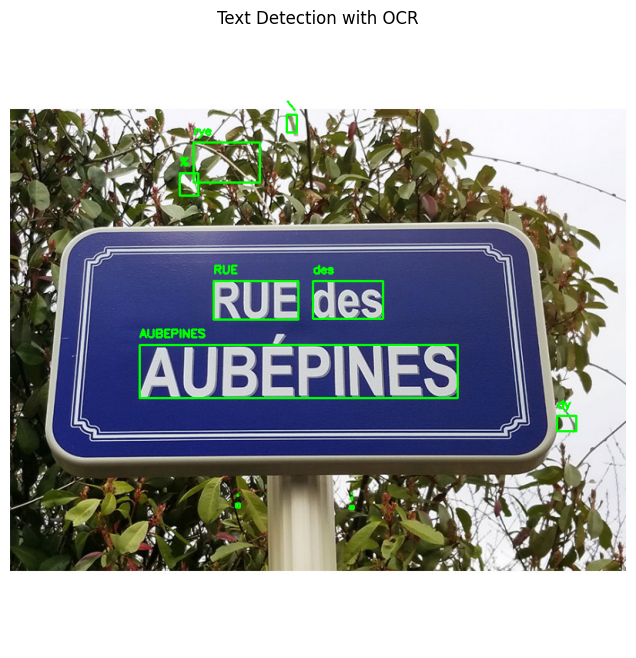

In [6]:
# Charger une image
image_path = '/Users/quentinpierson/Documents/AssistEye/Yolo-dist-text-detection-webcam/test.jpg'
image = cv2.imread(image_path)

# Prétraitement de l'image pour OCR
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)
_, binary = cv2.threshold(gray, 150, 255, cv2.THRESH_BINARY_INV)

# Détection de texte
data = pytesseract.image_to_data(binary, output_type=pytesseract.Output.DICT, config='--psm 6')
n_boxes = len(data['level'])
for i in range(n_boxes):
    if int(data['conf'][i]) > 60:  # Filtrer les résultats avec une confiance > 60
        (x, y, w, h) = (data['left'][i], data['top'][i], data['width'][i], data['height'][i])
        text = data['text'][i]
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)  # Dessiner le rectangle
        cv2.putText(image, text, (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 2)  # Dessiner le texte

# Convertir l'image annotée en RGB pour matplotlib
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Afficher l'image avec matplotlib
plt.figure(figsize=(12, 8))
plt.imshow(image_rgb)
plt.title("Text Detection with OCR")
plt.axis('off')
plt.show()

# Organisation de l'interaction entre les différents modèles

Nous allons expliquer comment les différents modules du projet **AssistEye** interagissent pour fournir une détection d'objets enrichie par l'estimation de la profondeur, ainsi que la détection de texte sur les objets détectés. L'utilisation du module **AssistEye** simplifie le code et rend l'explication des interactions plus claire.

## 1. Configuration de la carte de profondeur

Nous commençons par configurer le module de profondeur pour estimer la carte de profondeur de l'image. Le module **depth** utilise le modèle MiDaS pour estimer la profondeur de chaque pixel de l'image. Cette carte de profondeur sera utilisée pour déterminer la distance des objets détectés par rapport à la caméra.

AssistEye config loaded successfully.
Initializing object detection model...
Model: yolo11n.pt, Device: mps


Using cache found in /Users/quentinpierson/.cache/torch/hub/intel-isl_MiDaS_master


Loading weights:  None


Using cache found in /Users/quentinpierson/.cache/torch/hub/rwightman_gen-efficientnet-pytorch_master


AssistEye module loaded successfully.


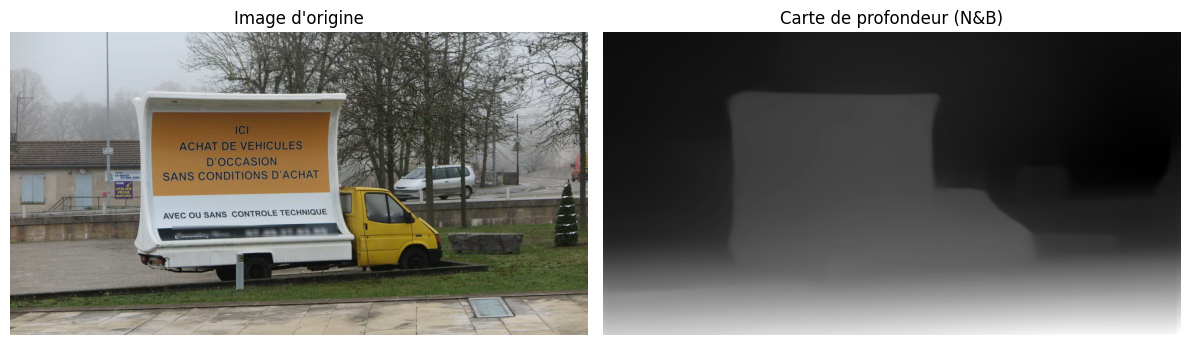

In [7]:
from AssistEye import depth

# Charger l'image
image_path = 'truck.jpg'
image = np.array(Image.open(image_path))

# Estimer la profondeur
depth_map_normalized, processed_image = depth.configure_depth_map(image, depth, display_mode="grayscale")

# Affichage des images côte à côte
plt.figure(figsize=(12, 6))

# Image d'origine
plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title("Image d'origine")
plt.axis('off')

# Carte de profondeur en noir et blanc
plt.subplot(1, 2, 2)
plt.imshow(depth_map_normalized, cmap='gray')  # Utilisation de la colormap 'gray'
plt.title("Carte de profondeur (N&B)")
plt.axis('off')

# Affichage
plt.tight_layout()
plt.show()

## 2. Combinaison avec la détection d'objets (YOLO)

Nous fournissons l'image et la carte de profondeur au module **objectDetection** pour combiner la détection d'objets avec l'estimation de la profondeur. Le modèle YOLO détecte les objets dans une image, tandis que MiDaS fonctionne sur des régions d'intérêt (ROI), ce qui rend leur utilisation conjointe cohérente.

En utilisant la méthode process_results du module **objectDetection**, nous pouvons récupérer le nombre d'objets détectés, leur distance estimée par rapport à la caméra, ainsi que leurs positions dans l'image.

In [8]:
from AssistEye.detection import objectDetection

# Détecter les objets dans l'image
results = objectDetection.detect(image)

# Traiter les résultats pour obtenir les comptes, les distances et les positions
object_counts, distances, positions = objectDetection.process_results(
    results, depth_map_normalized, return_positions=True
)


0: 352x640 1 car, 2 trucks, 427.7ms
Speed: 8.8ms preprocess, 427.7ms inference, 92.6ms postprocess per image at shape (1, 3, 352, 640)


- **object_counts** : un dictionnaire contenant le nombre d'objets détectés pour chaque classe.
- **distances** : un dictionnaire contenant les distances estimées pour chaque classe d'objets.
- **positions** : un dictionnaire contenant les positions (coordonnées des boîtes englobantes) des objets détectés.

In [9]:
# Afficher les résultats
print("Nombre d'objets détectés:", object_counts)
print("Distances aux objets:", distances)
print("Positions des objets:", positions)

Nombre d'objets détectés: {'truck': 2, 'car': 1}
Distances aux objets: {'truck': [2.760698512690219, 2.22745890392128], 'car': [8.88513859377116]}
Positions des objets: {'truck': [(258, 125, 896, 522), (258, 321, 898, 524)], 'car': [(795, 275, 968, 351)]}


### Affichage des boundings boxes


0: 352x640 1 car, 2 trucks, 17.5ms
Speed: 2.0ms preprocess, 17.5ms inference, 5.3ms postprocess per image at shape (1, 3, 352, 640)


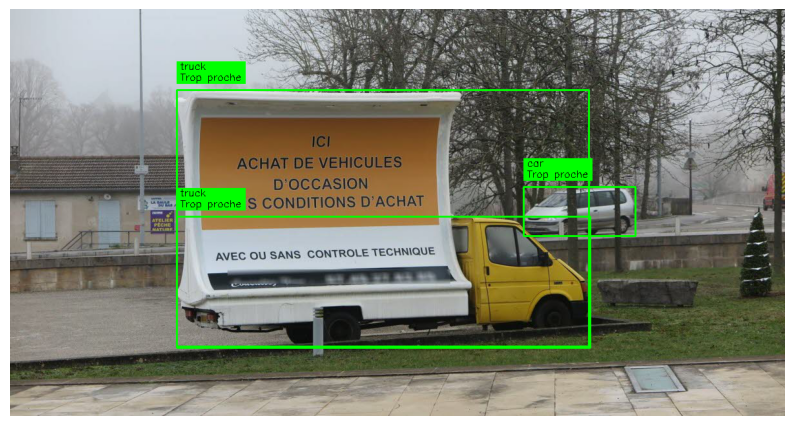

In [10]:
annotations = {
    'class': True,
    'confidence': False,
    'distance': True,
}
objectDetection.run_inference(image_path, annotations)

### Note sur l'affichage des boîtes englobantes

Lors de l'affichage des boîtes englobantes, vous remarquerez peut-être que certaines indiquent la mention "Trop proche". Cela est normal car les paramètres de distance sont préconfigurée dans le fichier de configuration, il faut donc les modifier afin d'obtenir des résultats plus pertinents.

Les facteurs de distance sont ajustés pour des cas d'utilisation où le système fonctionne sur des dispositifs tels que des lunettes connectées, un téléphone ou une webcam.

## 4. Extraction des régions d'intérêt pour la détection de texte

Avec les positions des objets détectés, nous pouvons extraire des régions d'intérêt (ROIs) de l'image originale. Cela permet d'effectuer une détection de texte ciblée avec Tesseract sur les zones précises où le texte est susceptible d'être présent, réduisant ainsi le risque de détection de texte non pertinent.

In [11]:
# Extraire les régions contenant les objets détectés
cropped_regions = objectDetection.crop_objects(image, positions)



## 5. Détection de texte sur les objets détectés

Pour chaque région extraite, nous utilisons le module **textDetection** pour effectuer la détection de texte. La méthode detect permet d'obtenir plusieurs résultats potentiels, et nous pouvons ensuite sélectionner les meilleurs résultats en fonction de critères tels que la confiance ou la pertinence.

Texte détecté sur l'objet 'truck': (['AVEC', 'OU', 'SANS', 'CONTROLE', 'TECHNIQUE', ''], [(62, 252, 44, 12), (114, 251, 24, 12), (145, 250, 47, 12), (203, 247, 91, 13), (303, 244, 95, 13), (0, 0, 638, 397)])


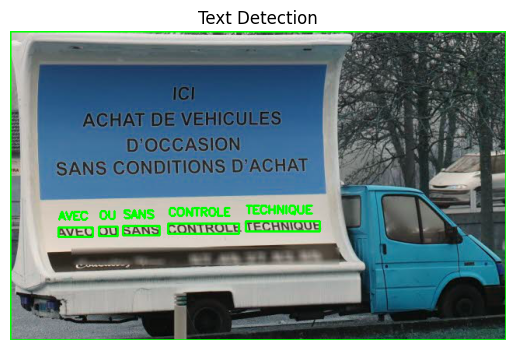

Texte détecté sur l'objet 'truck': (['E', 'OU', 'SANS.', 'CONTROLE', 'TECHNIQUE', '-', 'SYED', 'OO', 'GANS', 'CONTROTY', 'CECHNIOUY:', 'mot', 'ee', 'Sen', 'ed', '   ', ' ', ' ', ' ', ' ', ''], [(94, 27, 5, 2), (117, 17, 18, 36), (142, 25, 44, 21), (198, 21, 104, 22), (303, 21, 98, 20), (396, 17, 9, 36), (54, 41, 53, 34), (118, 41, 20, 34), (149, 41, 43, 34), (203, 41, 91, 34), (305, 41, 101, 34), (56, 85, 91, 30), (172, 93, 40, 12), (365, 78, 28, 30), (403, 78, 15, 30), (0, 0, 100, 98), (421, 0, 219, 68), (421, 68, 219, 30), (0, 98, 56, 47), (416, 98, 224, 47), (0, 145, 640, 58)])


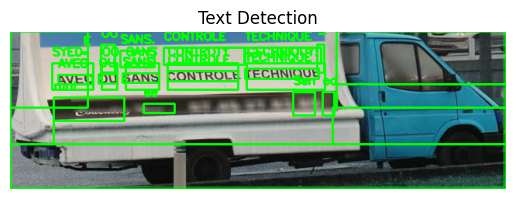

Texte détecté sur l'objet 'car': ([''], [(0, 0, 173, 76)])


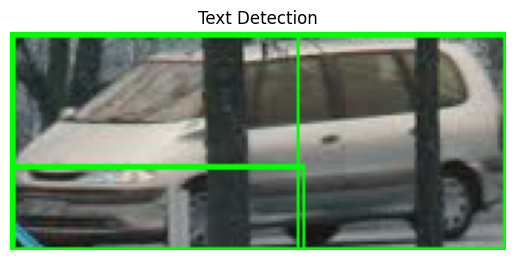

In [13]:
from AssistEye.detection import textDetection

annotations = {
    'class': True,
    'confidence': True
}

# Parcourir les régions recadrées et effectuer la détection de texte
for class_name, regions in cropped_regions.items():
    for region in regions:
        # Effectuer la détection de texte sur la région
        text_results = textDetection.detect(region)
        # Traiter les résultats pour obtenir le meilleur texte détecté
        best_text = textDetection.process_results(text_results)
        print(f"Texte détecté sur l'objet '{class_name}': {best_text}")
        # Afficher l'image annotée avec le texte détecté pour vérification
        textDetection.run_inference(region, annotations)

## Explication du processus de détection de texte

Le module **textDetection** utilise Tesseract pour la reconnaissance optique des caractères (OCR) sur les images fournies. En se concentrant sur les régions où les objets ont été détectés, nous améliorons la précision de la détection de texte en réduisant le bruit et en évitant les zones non pertinentes de l'image.

La méthode detect du module **textDetection** effectue l'OCR sur une image donnée et renvoie les textes détectés. Ensuite, la méthode process_results traite ces textes pour filtrer les résultats et conserver les plus pertinents.

## Résumé de l'interaction entre les modules

- **Configuration de la profondeur** : Le module **depth** estime la carte de profondeur de l'image, indispensable pour calculer les distances aux objets.
- **Détection d'objets** : Le module **objectDetection** utilise YOLO pour détecter les objets et, grâce à la carte de profondeur, estime leurs distances.
- **Extraction des ROIs** : Les positions des objets détectés sont utilisées pour extraire les régions correspondantes de l'image originale.
- **Détection de texte** : Le module **textDetection** applique l'OCR sur ces régions pour détecter du texte.
- **Combinaison des résultats** : Les informations sur les objets, leurs distances et les textes détectés sont combinées pour fournir une compréhension enrichie de l'image.